# Part 3: Re-track SX5E Index

D'après la méthode de Heaton, on peut remarquer que la première partie de l'application (dans le research paper) a pour but la sélection d'un sous-ensemble d'actions du SX5E Stock. Cette démarche vise à son tour de faire la même performance que l'index.

La méthode de Heaton possède 4 phases:

- Auto-Encoding
- Calibration
- Validation
- Vérification

In [25]:
# Run some setup code for this notebook.
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Phase 0: Loading Data **

- Nous avons 48 actions à étudier.

In [33]:
lastPricePath = 'data/SX5E/close.csv'
netChangePath = 'data/SX5E/rendement.csv'
percentageChangePath = 'data/SX5E/taux.csv'
stockPath = 'data/SX5E/SX5E.csv'

startDateCalibrate = 1
endDateCalibrate = 2014
startDateValidate = 2015
endDateValidate = 2045


# Load data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv(lastPricePath, index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[startDateCalibrate:endDateCalibrate+1, :]
stock['validate']['lp'] = stock_lp.iloc[startDateValidate:endDateValidate, :]
print("close: ",len(stock_lp.columns))

stock_net = pd.read_csv(netChangePath, index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[startDateCalibrate:endDateCalibrate+1, :]
stock['validate']['net'] = stock_net.iloc[startDateValidate:endDateValidate, :]
print("rendement: ", len(stock_net.columns))

stock_percentage = pd.read_csv(percentageChangePath, index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[startDateCalibrate:endDateCalibrate+1, :]
stock['validate']['percentage'] = stock_percentage.iloc[startDateValidate:endDateValidate, :]
print("taux de rendement", len(stock_percentage.columns))

# ibb
stockIndex = defaultdict(defaultdict)
stockIndex_full = pd.read_csv(stockPath, index_col=0).astype('float32')

stockIndex_lp = stockIndex_full.iloc[:,0] # Series
stockIndex['calibrate']['lp'] = stockIndex_lp[startDateCalibrate:endDateCalibrate+1]
stockIndex['validate']['lp'] = stockIndex_lp[startDateValidate:endDateValidate]

stockIndex_net = stockIndex_full.iloc[:,1] # Series
stockIndex['calibrate']['net'] = stockIndex_net[startDateCalibrate:endDateCalibrate+1]
stockIndex['validate']['net'] = stockIndex_net[startDateValidate:endDateValidate]

stockIndex_percentage = stockIndex_full.iloc[:,2] # Series
stockIndex['calibrate']['percentage'] = stockIndex_percentage[startDateCalibrate:endDateCalibrate+1]
stockIndex['validate']['percentage'] = stockIndex_percentage[startDateValidate:endDateValidate]

print(stockIndex_full.iloc[startDateCalibrate:startDateCalibrate+1,0])
print(stockIndex_full.iloc[endDateCalibrate:endDateCalibrate+1,0])
print(stockIndex_full.iloc[startDateValidate:startDateValidate+1,0])
print(stockIndex_full.iloc[endDateValidate:endDateValidate+1,0])

close:  48
rendement:  48
taux de rendement 48
Date
29/01/2010    2776.830078
Name: Close, dtype: float32
Date
11/12/2017    3582.209961
Name: Close, dtype: float32
Date
12/12/2017    3600.350098
Name: Close, dtype: float32
Date
26/01/2018    3647.409912
Name: Close, dtype: float32


In [34]:
stock_lp.head()

,"ABI,BR","AI,PA","AIR,PA","ALV,DE","ASML,AS","BAS,DE","BAYN,DE","BBVA,MC","BMW,DE","BN,PA",...,"SAN,PA","SAP,DE","SGO,PA","SIE,DE","SU,PA","TEF,MC","UCG,MI","UL,AS","VIV,PA","VOW3,DE"
Date,,,,,,,,,,,,,,,,,,,,,
1/28/2010,35.160000,56.699600,13.775,79.570000,29.655800,40.025002,49.279999,10.5442,29.549999,40.904999,...,52.680000,32.180000,33.375000,62.889999,36.875000,17.079300,64.118202,155.350006,18.251600,56.162201
1/29/2010,36.150002,57.879902,14.200,80.419998,29.831200,41.224998,49.474998,10.6643,30.959999,41.445000,...,53.599998,33.080002,34.849998,63.015999,37.514999,17.168301,66.659203,157.199997,18.241899,58.249599
2/1/2010,36.349998,59.015099,14.275,80.489998,29.779200,41.730000,49.610001,10.6787,31.065001,41.650002,...,53.230000,33.584999,34.264999,63.035400,37.654999,17.128799,67.896698,159.300003,17.801600,60.257500
2/2/2010,36.685001,59.902199,14.610,81.190002,30.181801,42.000000,50.000000,10.7988,31.174999,41.849998,...,53.799999,33.794998,35.139999,64.052902,38.494999,17.222700,70.124100,158.949997,18.014500,60.674999
2/3/2010,36.465000,59.353401,14.625,80.410004,30.480499,42.130001,49.195000,10.3472,31.225000,42.110001,...,54.060001,34.049999,35.264999,63.442402,38.529999,17.099100,69.134102,158.000000,18.043600,61.132301


In [35]:
stock_net.head()

,ABI.BR,AI.PA,AIR.PA,ALV.DE,ASML.AS,BAS.DE,BAYN.DE,BBVA.MC,BMW.DE,BN.PA,...,SAN.PA,SAP.DE,SGO.PA,SIE.DE,SU.PA,TEF.MC,UCG.MI,UL.AS,VIV.PA,VOW3.DE
Date,,,,,,,,,,,,,,,,,,,,,
1/28/2010,-0.154999,-1.413300,-0.020,-1.430000,-0.272800,-0.319999,-1.530002,-0.2786,-0.040001,-1.055000,...,-1.119999,-0.570000,-0.650002,-2.015603,-1.395000,-0.499300,-2.706001,1.950012,-0.416100,0.308201
1/29/2010,0.990002,1.180302,0.425,0.849998,0.175400,1.199996,0.194999,0.1201,1.410000,0.540001,...,0.919998,0.900002,1.474998,0.126000,0.639999,0.089001,2.541001,1.849991,-0.009701,2.087398
2/1/2010,0.199996,1.135197,0.075,0.070000,-0.052000,0.505002,0.135003,0.0144,0.105002,0.205002,...,-0.369998,0.504997,-0.584999,0.019401,0.140000,-0.039502,1.237495,2.100006,-0.440299,2.007901
2/2/2010,0.335003,0.887100,0.335,0.700004,0.402601,0.270000,0.389999,0.1201,0.109998,0.199996,...,0.569999,0.209999,0.875000,1.017502,0.840000,0.093901,2.227402,-0.350006,0.212900,0.417499
2/3/2010,-0.220001,-0.548798,0.015,-0.779998,0.298698,0.130001,-0.805000,-0.4516,0.050001,0.260003,...,0.260002,0.255001,0.125000,-0.610500,0.035000,-0.123600,-0.989998,-0.949997,0.029100,0.457302


In [36]:
stock_percentage.head()

,ABI.BR,AI.PA,AIR.PA,ALV.DE,ASML.AS,BAS.DE,BAYN.DE,BBVA.MC,BMW.DE,BN.PA,...,SAN.PA,SAP.DE,SGO.PA,SIE.DE,SU.PA,TEF.MC,UCG.MI,UL.AS,VIV.PA,VOW3.DE
Date,,,,,,,,,,,,,,,,,,,,,
1/28/2010,-0.438904,-2.431990,-0.144980,-1.765432,-0.911503,-0.793157,-3.011222,-2.574195,-0.135184,-2.514299,...,-2.081783,-1.740458,-1.910366,-3.105438,-3.645153,-2.840385,-4.049432,1.271194,-2.228984,0.551798
1/29/2010,2.815705,2.081676,3.085299,1.068239,0.591453,2.998116,0.395696,1.139015,4.771574,1.320135,...,1.746390,2.796774,4.419470,0.200350,1.735590,0.521105,3.962995,1.190853,-0.053152,3.716731
2/1/2010,0.553239,1.961297,0.528169,0.087043,-0.174314,1.224990,0.272871,0.135030,0.339154,0.494636,...,-0.690295,1.526593,-1.678620,0.030787,0.373184,-0.230087,1.856450,1.335882,-2.413669,3.447064
2/2/2010,0.921604,1.503175,2.346760,0.869678,1.351954,0.647017,0.786130,1.124669,0.354090,0.480182,...,1.070823,0.625276,2.553626,1.614176,2.230779,0.548205,3.280575,-0.219715,1.195960,0.692858
2/3/2010,-0.599703,-0.916157,0.102669,-0.960707,0.989663,0.309526,-1.610000,-4.181946,0.160388,0.621274,...,0.483275,0.754552,0.355720,-0.953118,0.090921,-0.717658,-1.411780,-0.597670,0.161537,0.753691


In [37]:
stockIndex_full.head()

,Close,rendement,taux de rendement,Volume,Unnamed: 5,Unnamed: 6
Date,,,,,,
28/01/2010,2737.330078,-50.069824,-1.796291,0.0,NaN,NaN
29/01/2010,2776.830078,39.500000,1.443012,0.0,NaN,NaN
01/02/2010,2793.290039,16.459961,0.592761,0.0,NaN,NaN
02/02/2010,2830.010010,36.719971,1.314578,0.0,NaN,NaN
03/02/2010,2804.610107,-25.399902,-0.897520,0.0,NaN,NaN


** Phase 1: Auto-encoding**

1. Apprentissage d'un auto-encoder afin de compresser l'information sur le marché (les actions du stock)
2. Classer les actions du Stock avec une norme 2
3. sélection d'un sous ensemble du stock comme un portefeuille
4. Page 7 dans le research paper: ReLU + linear comme des fonctions d'activation
5. Poids $W = (W_1, W_2)$, L2 regularization

In [38]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) 

# connect all layers
input_img = Input(shape=(num_stock,))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, batch_size = 10, epochs=500, shuffle=False)
autoencoder.save('model/CAC40/autoencoder.h5')

# how well is our re-construct matrix?
reconstruct = autoencoder.predict(data)

Epoch 1/500
2014/2014 [==============================] - 2s 763us/step - loss: 6.3159
Epoch 2/500
2014/2014 [==============================] - 1s 319us/step - loss: 2.0062
Epoch 3/500
2014/2014 [==============================] - 1s 321us/step - loss: 2.0996
Epoch 4/500
2014/2014 [==============================] - 1s 332us/step - loss: 2.1780 0s - loss: 2.41
Epoch 5/500
2014/2014 [==============================] - 1s 316us/step - loss: 1.7310
Epoch 6/500
2014/2014 [==============================] - 1s 322us/step - loss: 1.4763
Epoch 7/500
2014/2014 [==============================] - 1s 326us/step - loss: 1.1304
Epoch 8/500
2014/2014 [==============================] - 1s 327us/step - loss: 0.8433
Epoch 9/500
2014/2014 [==============================] - 1s 321us/step - loss: 0.7810
Epoch 10/500
2014/2014 [==============================] - 1s 330us/step - loss: 0.7328
Epoch 11/500
2014/2014 [==============================] - 1s 340us/step - loss: 0.7119
Epoch 12/500
2014/2014 [============

2014/2014 [==============================] - 0s 107us/step - loss: 0.6573
Epoch 187/500
2014/2014 [==============================] - 0s 106us/step - loss: 0.6989
Epoch 188/500
2014/2014 [==============================] - 0s 120us/step - loss: 0.6533
Epoch 189/500
2014/2014 [==============================] - 0s 105us/step - loss: 0.6783
Epoch 190/500
2014/2014 [==============================] - 0s 107us/step - loss: 0.6538
Epoch 191/500
2014/2014 [==============================] - 0s 134us/step - loss: 0.6713
Epoch 192/500
2014/2014 [==============================] - 0s 107us/step - loss: 0.6858
Epoch 193/500
2014/2014 [==============================] - 0s 111us/step - loss: 0.6539
Epoch 194/500
2014/2014 [==============================] - 0s 110us/step - loss: 0.6772
Epoch 195/500
2014/2014 [==============================] - 0s 119us/step - loss: 0.6538
Epoch 196/500
2014/2014 [==============================] - 0s 120us/step - loss: 0.6661
Epoch 197/500
2014/2014 [=====================

2014/2014 [==============================] - 1s 336us/step - loss: 0.6555
Epoch 372/500
2014/2014 [==============================] - 1s 366us/step - loss: 0.6720
Epoch 373/500
2014/2014 [==============================] - 1s 352us/step - loss: 0.6681
Epoch 374/500
2014/2014 [==============================] - 1s 315us/step - loss: 0.6848
Epoch 375/500
2014/2014 [==============================] - 1s 301us/step - loss: 0.6572
Epoch 376/500
2014/2014 [==============================] - 1s 297us/step - loss: 0.6671
Epoch 377/500
2014/2014 [==============================] - 1s 274us/step - loss: 0.6801
Epoch 378/500
2014/2014 [==============================] - 1s 258us/step - loss: 0.6658
Epoch 379/500
2014/2014 [==============================] - 1s 283us/step - loss: 0.6585
Epoch 380/500
2014/2014 [==============================] - 1s 266us/step - loss: 0.6614
Epoch 381/500
2014/2014 [==============================] - 1s 318us/step - loss: 0.6555
Epoch 382/500
2014/2014 [=====================

2014/2014 [==============================] - 0s 138us/step - loss: 0.6609
Epoch 465/500
2014/2014 [==============================] - 0s 139us/step - loss: 0.6631
Epoch 466/500
2014/2014 [==============================] - 0s 134us/step - loss: 0.6788
Epoch 467/500
2014/2014 [==============================] - 0s 200us/step - loss: 0.6601
Epoch 468/500
2014/2014 [==============================] - 1s 568us/step - loss: 0.6844
Epoch 469/500
2014/2014 [==============================] - 1s 593us/step - loss: 0.6684
Epoch 470/500
2014/2014 [==============================] - 1s 409us/step - loss: 0.6553
Epoch 471/500
2014/2014 [==============================] - 1s 430us/step - loss: 0.6506
Epoch 472/500
2014/2014 [==============================] - 1s 481us/step - loss: 0.6628
Epoch 473/500
2014/2014 [==============================] - 1s 339us/step - loss: 0.6847
Epoch 474/500
2014/2014 [==============================] - 1s 293us/step - loss: 0.6684
Epoch 475/500
2014/2014 [=====================

** Communal Information **

- calculer les normes 2 $||X - \hat{X}||$
- L'action, celle qui la minimum valeur en norme 2, a le role le plus important dans la compression des données du marché dans l'auto-encoder

In [39]:
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock number | 2-norm | stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index,"|", communal_information[stock_index],"|", stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock number | 2-norm | stock name
28 | 1.7942237854003906 | ISP.MI
19 | 2.082322835922241 | ENEL.MI
26 | 3.0994338989257812 | IBE.MC
37 | 5.5825724601745605 | SAN.MC
7 | 6.197340488433838 | BBVA.MC
17 | 6.262083053588867 | DTE.DE
22 | 6.444415092468262 | EOAN.DE
27 | 6.732735633850098 | INGA.AS
33 | 6.897491455078125 | ORA.PA
43 | 7.556789875030518 | TEF.MC
21 | 8.062179565429688 | ENI.MI
24 | 8.42071533203125 | G.MI
12 | 9.928558349609375 | CS.PA
46 | 10.158340454101562 | VIV.PA
16 | 10.341205596923828 | DPW.DE
20 | 11.122055053710938 | ENGI.PA
35 | 12.213456153869629 | REP.MC
34 | 13.05994987487793 | PHIA.AS
11 | 15.56692886352539 | CA.PA
23 | 18.953418731689453 | FP.PA
14 | 19.744428634643555 | DBK.DE
36 | 20.440805435180664 | RWE.DE
40 | 21.256656646728516 | SGO.PA
15 | 22.27066421508789 | DG.PA
9 | 23.45339584350586 | BN.PA
39 | 24.498973846435547 | SAP.DE
13 | 26.809926986694336 | DAI.DE
25 | 29.079164505004883 | GLE.PA
5 | 29.20530128479004 | BAS.DE
2 | 29.390247344970703 | AIR

Notre Auto-encoder est construit maintenant. Nous allons tracer les actions (auto-encoded).

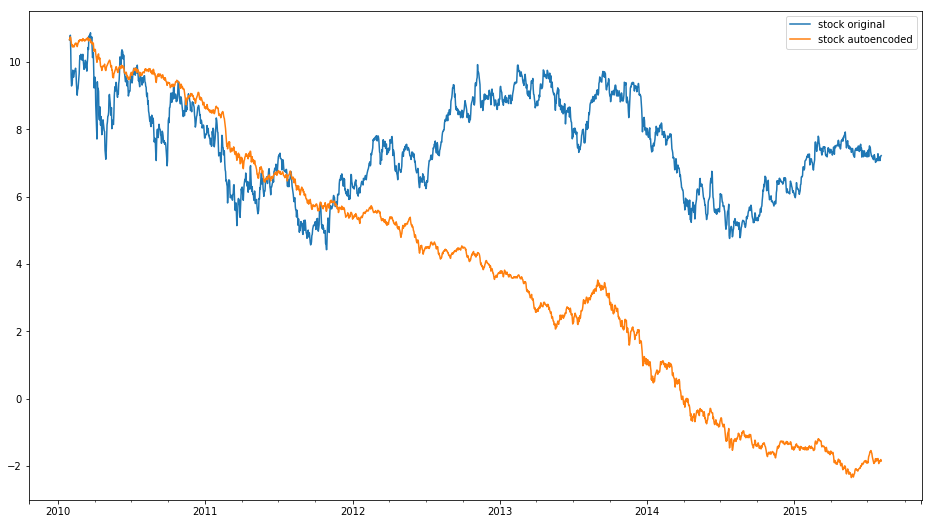

In [46]:
which_stock = 7

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum() # the stock evolution from net change values 
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock]) # add the initial stock value

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/29/2010', periods=2014, freq='D')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/29/2010', periods = 2014,freq='D')).plot(label='stock autoencoded', legend=True)

**Phase 2: Calibration**

- x : taux de rendement du portefeuille construit
- y : taux de rendement de l'indice du stock

In [48]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [5,15,25,35]:  
    # some numerical values
    encoding_dim = 5
    s = 5 + non_communal
    stock_index = np.concatenate((ranking[0:5], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.001))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = stockIndex['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
   
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 100)    # fit the model
    deep_learner.save('model/SX5E/s(' + str(s) + ')' + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = stockIndex['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - stockIndex['calibrate']['lp']))

Epoch 1/500
2014/2014 [==============================] - 1s 505us/step - loss: 1.3410
Epoch 2/500
2014/2014 [==============================] - 0s 53us/step - loss: 1.0227
Epoch 3/500
2014/2014 [==============================] - 0s 49us/step - loss: 0.8276
Epoch 4/500
2014/2014 [==============================] - 0s 43us/step - loss: 0.6578
Epoch 5/500
2014/2014 [==============================] - 0s 46us/step - loss: 0.5359
Epoch 6/500
2014/2014 [==============================] - 0s 50us/step - loss: 0.4655
Epoch 7/500
2014/2014 [==============================] - 0s 60us/step - loss: 0.4236
Epoch 8/500
2014/2014 [==============================] - 0s 51us/step - loss: 0.3962
Epoch 9/500
2014/2014 [==============================] - 0s 57us/step - loss: 0.3770
Epoch 10/500
2014/2014 [==============================] - 0s 45us/step - loss: 0.3630
Epoch 11/500
2014/2014 [==============================] - 0s 47us/step - loss: 0.3526
Epoch 12/500
2014/2014 [==============================] - 0s 5

2014/2014 [==============================] - 0s 20us/step - loss: 0.2712
Epoch 97/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2711
Epoch 98/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2710
Epoch 99/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2709
Epoch 100/500
2014/2014 [==============================] - 0s 23us/step - loss: 0.2708
Epoch 101/500
2014/2014 [==============================] - 0s 25us/step - loss: 0.2706
Epoch 102/500
2014/2014 [==============================] - 0s 22us/step - loss: 0.2705
Epoch 103/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2704
Epoch 104/500
2014/2014 [==============================] - 0s 28us/step - loss: 0.2703
Epoch 105/500
2014/2014 [==============================] - 0s 31us/step - loss: 0.2702
Epoch 106/500
2014/2014 [==============================] - 0s 22us/step - loss: 0.2701
Epoch 107/500
2014/2014 [==============================] - 0

2014/2014 [==============================] - 0s 18us/step - loss: 0.2639
Epoch 191/500
2014/2014 [==============================] - 0s 25us/step - loss: 0.2639
Epoch 192/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2639
Epoch 193/500
2014/2014 [==============================] - 0s 19us/step - loss: 0.2638
Epoch 194/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2638
Epoch 195/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2638
Epoch 196/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2638
Epoch 197/500
2014/2014 [==============================] - 0s 22us/step - loss: 0.2638
Epoch 198/500
2014/2014 [==============================] - 0s 22us/step - loss: 0.2637
Epoch 199/500
2014/2014 [==============================] - 0s 22us/step - loss: 0.2637
Epoch 200/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2637
Epoch 201/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 27us/step - loss: 0.2618
Epoch 379/500
2014/2014 [==============================] - 0s 26us/step - loss: 0.2618
Epoch 380/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2618
Epoch 381/500
2014/2014 [==============================] - 0s 19us/step - loss: 0.2618
Epoch 382/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2618
Epoch 383/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2618
Epoch 384/500
2014/2014 [==============================] - 0s 19us/step - loss: 0.2618
Epoch 385/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2618
Epoch 386/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2618
Epoch 387/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2618
Epoch 388/500
2014/2014 [==============================] - 0s 19us/step - loss: 0.2618
Epoch 389/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 22us/step - loss: 0.2614
Epoch 473/500
2014/2014 [==============================] - 0s 26us/step - loss: 0.2614
Epoch 474/500
2014/2014 [==============================] - 0s 34us/step - loss: 0.2614
Epoch 475/500
2014/2014 [==============================] - 0s 26us/step - loss: 0.2614
Epoch 476/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2614
Epoch 477/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2614
Epoch 478/500
2014/2014 [==============================] - 0s 18us/step - loss: 0.2614
Epoch 479/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.2614
Epoch 480/500
2014/2014 [==============================] - 0s 20us/step - loss: 0.2614
Epoch 481/500
2014/2014 [==============================] - 0s 26us/step - loss: 0.2614
Epoch 482/500
2014/2014 [==============================] - 0s 22us/step - loss: 0.2614
Epoch 483/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 17us/step - loss: 0.1723
Epoch 162/500
2014/2014 [==============================] - 0s 18us/step - loss: 0.1722
Epoch 163/500
2014/2014 [==============================] - 0s 19us/step - loss: 0.1722
Epoch 164/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1721
Epoch 165/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1721
Epoch 166/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1721
Epoch 167/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1720
Epoch 168/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1720
Epoch 169/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1719
Epoch 170/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1719
Epoch 171/500
2014/2014 [==============================] - 0s 17us/step - loss: 0.1718
Epoch 172/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 16us/step - loss: 0.1683
Epoch 350/500
2014/2014 [==============================] - 0s 18us/step - loss: 0.1683
Epoch 351/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1683
Epoch 352/500
2014/2014 [==============================] - 0s 18us/step - loss: 0.1683
Epoch 353/500
2014/2014 [==============================] - 0s 23us/step - loss: 0.1683
Epoch 354/500
2014/2014 [==============================] - 0s 21us/step - loss: 0.1682
Epoch 355/500
2014/2014 [==============================] - 0s 18us/step - loss: 0.1682
Epoch 356/500
2014/2014 [==============================] - 0s 19us/step - loss: 0.1682
Epoch 357/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1682
Epoch 358/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1682
Epoch 359/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1682
Epoch 360/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 15us/step - loss: 0.1811
Epoch 38/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1800
Epoch 39/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1790
Epoch 40/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1780
Epoch 41/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1770
Epoch 42/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1761
Epoch 43/500
2014/2014 [==============================] - 0s 13us/step - loss: 0.1752
Epoch 44/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1744
Epoch 45/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1735
Epoch 46/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1727
Epoch 47/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1720
Epoch 48/500
2014/2014 [==============================] - 0s 14us/s

2014/2014 [==============================] - 0s 13us/step - loss: 0.1478
Epoch 133/500
2014/2014 [==============================] - 0s 17us/step - loss: 0.1477
Epoch 134/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1476
Epoch 135/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1475
Epoch 136/500
2014/2014 [==============================] - 0s 17us/step - loss: 0.1474
Epoch 137/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1473
Epoch 138/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1472
Epoch 139/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1472
Epoch 140/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1471
Epoch 141/500
2014/2014 [==============================] - 0s 17us/step - loss: 0.1470
Epoch 142/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1469
Epoch 143/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 15us/step - loss: 0.1426
Epoch 227/500
2014/2014 [==============================] - 0s 18us/step - loss: 0.1426
Epoch 228/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1426
Epoch 229/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1425
Epoch 230/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1425
Epoch 231/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1425
Epoch 232/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1425
Epoch 233/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1424
Epoch 234/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1424
Epoch 235/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1424
Epoch 236/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1424
Epoch 237/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 32us/step - loss: 0.1395
Epoch 415/500
2014/2014 [==============================] - 0s 24us/step - loss: 0.1395
Epoch 416/500
2014/2014 [==============================] - 0s 19us/step - loss: 0.1395
Epoch 417/500
2014/2014 [==============================] - 0s 17us/step - loss: 0.1395
Epoch 418/500
2014/2014 [==============================] - 0s 18us/step - loss: 0.1394
Epoch 419/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1394
Epoch 420/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1394
Epoch 421/500
2014/2014 [==============================] - 0s 17us/step - loss: 0.1394
Epoch 422/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1394
Epoch 423/500
2014/2014 [==============================] - 0s 17us/step - loss: 0.1394
Epoch 424/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1394
Epoch 425/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 15us/step - loss: 0.1361
Epoch 104/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1360
Epoch 105/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1359
Epoch 106/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1358
Epoch 107/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1357
Epoch 108/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1357
Epoch 109/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1356
Epoch 110/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1355
Epoch 111/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1354
Epoch 112/500
2014/2014 [==============================] - 0s 13us/step - loss: 0.1353
Epoch 113/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1352
Epoch 114/500
2014/2014 [==============================] 

2014/2014 [==============================] - 0s 17us/step - loss: 0.1291
Epoch 291/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1291
Epoch 292/500
2014/2014 [==============================] - ETA: 0s - loss: 0.249 - 0s 15us/step - loss: 0.1291
Epoch 293/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1291
Epoch 294/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1291
Epoch 295/500
2014/2014 [==============================] - 0s 15us/step - loss: 0.1291
Epoch 296/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1291
Epoch 297/500
2014/2014 [==============================] - 0s 16us/step - loss: 0.1290
Epoch 298/500
2014/2014 [==============================] - 0s 13us/step - loss: 0.1290
Epoch 299/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1290
Epoch 300/500
2014/2014 [==============================] - 0s 14us/step - loss: 0.1290
Epoch 301/500
2014/2014 [========

2014/2014 [==============================] - 0s 38us/step - loss: 0.1273
Epoch 478/500
2014/2014 [==============================] - 0s 36us/step - loss: 0.1273
Epoch 479/500
2014/2014 [==============================] - 0s 34us/step - loss: 0.1273
Epoch 480/500
2014/2014 [==============================] - 0s 34us/step - loss: 0.1273
Epoch 481/500
2014/2014 [==============================] - 0s 59us/step - loss: 0.1273
Epoch 482/500
2014/2014 [==============================] - 0s 40us/step - loss: 0.1273
Epoch 483/500
2014/2014 [==============================] - 0s 26us/step - loss: 0.1273
Epoch 484/500
2014/2014 [==============================] - 0s 29us/step - loss: 0.1273
Epoch 485/500
2014/2014 [==============================] - 0s 28us/step - loss: 0.1273
Epoch 486/500
2014/2014 [==============================] - 0s 27us/step - loss: 0.1272
Epoch 487/500
2014/2014 [==============================] - 0s 25us/step - loss: 0.1272
Epoch 488/500
2014/2014 [==============================] 

Maintenant, on trace la performance des trois portefeuilles construits.

S(10) 2-norm difference:  5736.44
S(20) 2-norm difference:  8391.56
S(30) 2-norm difference:  8561.86
S(40) 2-norm difference:  7993.43


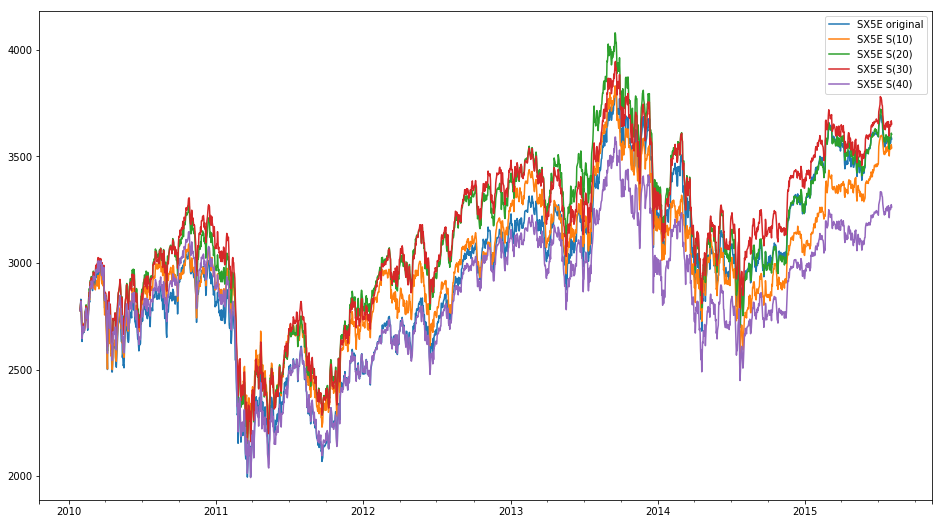

In [50]:
# plot results and 2-norm differences
pd.Series(stockIndex['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/29/2010', periods=2014, freq='D')).plot(label='SX5E original', legend=True) 
for s in [10, 20, 30, 40]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/29/2010', periods = 2014,freq='D')).plot(label='SX5E S('+str(s)+')', legend=True)
    print("S(" +str(s)+")" + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    

** Phase 3: Validation**

In [51]:
for non_communal in [5, 15, 25, 35]:  
    # some numerical values
    encoding_dim = 5
    s = 5 + non_communal
    stock_index = np.concatenate((ranking[0:5], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/SX5E/s(' + str(s) + ')' + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    y = stockIndex['validate']['percentage']

    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = stockIndex['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - stockIndex['validate']['lp']))

On prédit l'indice du SX5E avec les données de validation pour les 3 portefeuilles construits.

S(10) 2-norm difference:  129.637
S(20) 2-norm difference:  61.8705
S(30) 2-norm difference:  44.5344
S(40) 2-norm difference:  48.3884


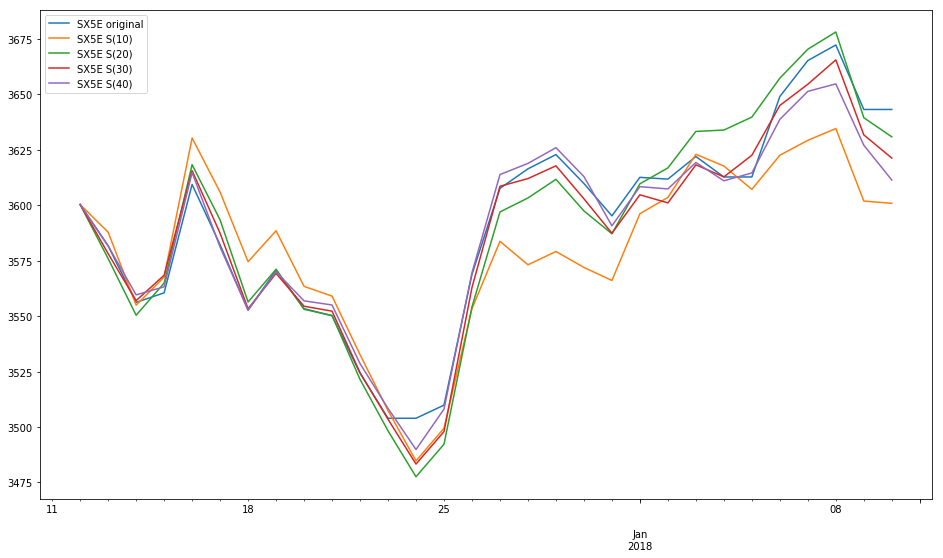

In [55]:
# plot results and 2-norm differences
pd.Series(stockIndex['validate']['lp'].as_matrix(), index=pd.date_range(start='12/12/2017', periods=30, freq='D')).plot(label='SX5E original', legend=True) 
for s in [10, 20, 30, 40]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='12/12/2017', periods = 30,freq='D')).plot(label='SX5E S('+str(s)+')', legend=True)
    print("S(" +str(s) +")" + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

**Phase 4: Vérification**

- axe des x: erreur en norme 2  
- axe des y: les portefeuilles construits 60, 40, 20


In [53]:
error = []
for non_communal in range(5, 26,5):  
    # some numerical values
    encoding_dim = 5
    s = 5 + non_communal
    stock_index = np.concatenate((ranking[0:5], ranking[-non_communal:])) # portfolio index


    # trainning
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = stockIndex['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = stockIndex['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = stockIndex['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - stockIndex['validate']['lp'])))    

Epoch 1/500
2014/2014 [==============================] - 3s 2ms/step - loss: 1.0626
Epoch 2/500
2014/2014 [==============================] - 1s 368us/step - loss: 0.7562
Epoch 3/500
2014/2014 [==============================] - 1s 352us/step - loss: 0.6653
Epoch 4/500
2014/2014 [==============================] - 1s 294us/step - loss: 0.5899
Epoch 5/500
2014/2014 [==============================] - 0s 247us/step - loss: 0.5258
Epoch 6/500
2014/2014 [==============================] - 1s 340us/step - loss: 0.4758
Epoch 7/500
2014/2014 [==============================] - 0s 220us/step - loss: 0.4396
Epoch 8/500
2014/2014 [==============================] - 0s 224us/step - loss: 0.4135
Epoch 9/500
2014/2014 [==============================] - 1s 250us/step - loss: 0.3944
Epoch 10/500
2014/2014 [==============================] - 1s 255us/step - loss: 0.3807
Epoch 11/500
2014/2014 [==============================] - 1s 288us/step - loss: 0.3699
Epoch 12/500
2014/2014 [==============================

2014/2014 [==============================] - 0s 122us/step - loss: 0.2896
Epoch 189/500
2014/2014 [==============================] - 0s 134us/step - loss: 0.2895
Epoch 190/500
2014/2014 [==============================] - 0s 130us/step - loss: 0.2896
Epoch 191/500
2014/2014 [==============================] - 0s 133us/step - loss: 0.2896
Epoch 192/500
2014/2014 [==============================] - 0s 123us/step - loss: 0.2895
Epoch 193/500
2014/2014 [==============================] - 0s 134us/step - loss: 0.2897
Epoch 194/500
2014/2014 [==============================] - 0s 127us/step - loss: 0.2896
Epoch 195/500
2014/2014 [==============================] - 0s 131us/step - loss: 0.2894
Epoch 196/500
2014/2014 [==============================] - 0s 131us/step - loss: 0.2896
Epoch 197/500
2014/2014 [==============================] - 0s 133us/step - loss: 0.2895
Epoch 198/500
2014/2014 [==============================] - 0s 129us/step - loss: 0.2894
Epoch 199/500
2014/2014 [=====================

2014/2014 [==============================] - 0s 243us/step - loss: 0.2891
Epoch 282/500
2014/2014 [==============================] - 0s 233us/step - loss: 0.2892
Epoch 283/500
2014/2014 [==============================] - 0s 226us/step - loss: 0.2889
Epoch 284/500
2014/2014 [==============================] - 0s 223us/step - loss: 0.2891
Epoch 285/500
2014/2014 [==============================] - 0s 226us/step - loss: 0.2891
Epoch 286/500
2014/2014 [==============================] - 0s 234us/step - loss: 0.2890
Epoch 287/500
2014/2014 [==============================] - 0s 227us/step - loss: 0.2891
Epoch 288/500
2014/2014 [==============================] - 0s 234us/step - loss: 0.2892
Epoch 289/500
2014/2014 [==============================] - 0s 225us/step - loss: 0.2891
Epoch 290/500
2014/2014 [==============================] - 0s 241us/step - loss: 0.2891
Epoch 291/500
2014/2014 [==============================] - 1s 250us/step - loss: 0.2893
Epoch 292/500
2014/2014 [=====================

2014/2014 [==============================] - 0s 120us/step - loss: 0.2902
Epoch 467/500
2014/2014 [==============================] - 0s 134us/step - loss: 0.2902
Epoch 468/500
2014/2014 [==============================] - 1s 639us/step - loss: 0.2901
Epoch 469/500
2014/2014 [==============================] - 1s 637us/step - loss: 0.2900
Epoch 470/500
2014/2014 [==============================] - 1s 507us/step - loss: 0.2902
Epoch 471/500
2014/2014 [==============================] - 1s 398us/step - loss: 0.2902
Epoch 472/500
2014/2014 [==============================] - 1s 397us/step - loss: 0.2901
Epoch 473/500
2014/2014 [==============================] - 1s 431us/step - loss: 0.2902
Epoch 474/500
2014/2014 [==============================] - 1s 320us/step - loss: 0.2903
Epoch 475/500
2014/2014 [==============================] - 1s 347us/step - loss: 0.2902
Epoch 476/500
2014/2014 [==============================] - 1s 357us/step - loss: 0.2901
Epoch 477/500
2014/2014 [=====================

2014/2014 [==============================] - 0s 189us/step - loss: 0.2157
Epoch 153/500
2014/2014 [==============================] - 0s 187us/step - loss: 0.2157
Epoch 154/500
2014/2014 [==============================] - 0s 183us/step - loss: 0.2156
Epoch 155/500
2014/2014 [==============================] - 0s 172us/step - loss: 0.2156
Epoch 156/500
2014/2014 [==============================] - 0s 174us/step - loss: 0.2158
Epoch 157/500
2014/2014 [==============================] - 0s 182us/step - loss: 0.2157
Epoch 158/500
2014/2014 [==============================] - 0s 182us/step - loss: 0.2157
Epoch 159/500
2014/2014 [==============================] - 0s 191us/step - loss: 0.2156
Epoch 160/500
2014/2014 [==============================] - 1s 275us/step - loss: 0.2158
Epoch 161/500
2014/2014 [==============================] - 0s 201us/step - loss: 0.2157 0s - loss: 0.
Epoch 162/500
2014/2014 [==============================] - 0s 138us/step - loss: 0.2156
Epoch 163/500
2014/2014 [=======

2014/2014 [==============================] - 1s 250us/step - loss: 0.2155
Epoch 338/500
2014/2014 [==============================] - 1s 258us/step - loss: 0.2155
Epoch 339/500
2014/2014 [==============================] - 0s 242us/step - loss: 0.2155
Epoch 340/500
2014/2014 [==============================] - 0s 247us/step - loss: 0.2156
Epoch 341/500
2014/2014 [==============================] - 0s 232us/step - loss: 0.2154
Epoch 342/500
2014/2014 [==============================] - 1s 294us/step - loss: 0.2155
Epoch 343/500
2014/2014 [==============================] - 1s 267us/step - loss: 0.2155
Epoch 344/500
2014/2014 [==============================] - 0s 243us/step - loss: 0.2154
Epoch 345/500
2014/2014 [==============================] - 0s 242us/step - loss: 0.2154
Epoch 346/500
2014/2014 [==============================] - 0s 240us/step - loss: 0.2156
Epoch 347/500
2014/2014 [==============================] - 0s 242us/step - loss: 0.2156
Epoch 348/500
2014/2014 [=====================

2014/2014 [==============================] - 1s 352us/step - loss: 0.1854
Epoch 23/500
2014/2014 [==============================] - 0s 225us/step - loss: 0.1849 0s - loss: 
Epoch 24/500
2014/2014 [==============================] - 0s 155us/step - loss: 0.1844
Epoch 25/500
2014/2014 [==============================] - 0s 164us/step - loss: 0.1840
Epoch 26/500
2014/2014 [==============================] - 0s 165us/step - loss: 0.1836
Epoch 27/500
2014/2014 [==============================] - 0s 190us/step - loss: 0.1834
Epoch 28/500
2014/2014 [==============================] - 0s 165us/step - loss: 0.1830
Epoch 29/500
2014/2014 [==============================] - 0s 178us/step - loss: 0.1828
Epoch 30/500
2014/2014 [==============================] - 0s 181us/step - loss: 0.1825
Epoch 31/500
2014/2014 [==============================] - 0s 172us/step - loss: 0.1822
Epoch 32/500
2014/2014 [==============================] - 0s 158us/step - loss: 0.1821
Epoch 33/500
2014/2014 [====================

Epoch 116/500
2014/2014 [==============================] - 0s 113us/step - loss: 0.1799
Epoch 117/500
2014/2014 [==============================] - 0s 110us/step - loss: 0.1799 0s - loss: 0.187
Epoch 118/500
2014/2014 [==============================] - 0s 117us/step - loss: 0.1799
Epoch 119/500
2014/2014 [==============================] - 0s 110us/step - loss: 0.1800
Epoch 120/500
2014/2014 [==============================] - 0s 107us/step - loss: 0.1800
Epoch 121/500
2014/2014 [==============================] - 0s 115us/step - loss: 0.1799
Epoch 122/500
2014/2014 [==============================] - 0s 111us/step - loss: 0.1800
Epoch 123/500
2014/2014 [==============================] - 0s 115us/step - loss: 0.1799
Epoch 124/500
2014/2014 [==============================] - 0s 111us/step - loss: 0.1798
Epoch 125/500
2014/2014 [==============================] - 0s 113us/step - loss: 0.1799
Epoch 126/500
2014/2014 [==============================] - 0s 109us/step - loss: 0.1799
Epoch 127/500
2

2014/2014 [==============================] - 1s 423us/step - loss: 0.1797
Epoch 301/500
2014/2014 [==============================] - 1s 321us/step - loss: 0.1796
Epoch 302/500
2014/2014 [==============================] - 1s 297us/step - loss: 0.1797
Epoch 303/500
2014/2014 [==============================] - 1s 302us/step - loss: 0.1796
Epoch 304/500
2014/2014 [==============================] - 1s 295us/step - loss: 0.1798
Epoch 305/500
2014/2014 [==============================] - 1s 315us/step - loss: 0.1797
Epoch 306/500
2014/2014 [==============================] - 1s 339us/step - loss: 0.1799
Epoch 307/500
2014/2014 [==============================] - 1s 408us/step - loss: 0.1795
Epoch 308/500
2014/2014 [==============================] - 1s 370us/step - loss: 0.1797
Epoch 309/500
2014/2014 [==============================] - 1s 379us/step - loss: 0.1797
Epoch 310/500
2014/2014 [==============================] - 1s 342us/step - loss: 0.1796
Epoch 311/500
2014/2014 [=====================

2014/2014 [==============================] - 1s 404us/step - loss: 0.1799
Epoch 486/500
2014/2014 [==============================] - 1s 310us/step - loss: 0.1797
Epoch 487/500
2014/2014 [==============================] - 1s 347us/step - loss: 0.1797
Epoch 488/500
2014/2014 [==============================] - 1s 304us/step - loss: 0.1797
Epoch 489/500
2014/2014 [==============================] - 1s 317us/step - loss: 0.1797
Epoch 490/500
2014/2014 [==============================] - 1s 293us/step - loss: 0.1798
Epoch 491/500
2014/2014 [==============================] - 1s 305us/step - loss: 0.1797
Epoch 492/500
2014/2014 [==============================] - 1s 314us/step - loss: 0.1799
Epoch 493/500
2014/2014 [==============================] - 1s 318us/step - loss: 0.1798
Epoch 494/500
2014/2014 [==============================] - 1s 326us/step - loss: 0.1797
Epoch 495/500
2014/2014 [==============================] - 1s 315us/step - loss: 0.1797
Epoch 496/500
2014/2014 [=====================

Epoch 79/500
2014/2014 [==============================] - 0s 119us/step - loss: 0.1640
Epoch 80/500
2014/2014 [==============================] - 0s 158us/step - loss: 0.1638 0s - loss: 0.14
Epoch 81/500
2014/2014 [==============================] - 0s 137us/step - loss: 0.1637 0s - loss: 0.172
Epoch 82/500
2014/2014 [==============================] - 0s 157us/step - loss: 0.1637
Epoch 83/500
2014/2014 [==============================] - 0s 119us/step - loss: 0.1637
Epoch 84/500
2014/2014 [==============================] - 0s 119us/step - loss: 0.1637
Epoch 85/500
2014/2014 [==============================] - 0s 110us/step - loss: 0.1637
Epoch 86/500
2014/2014 [==============================] - 0s 111us/step - loss: 0.1637
Epoch 87/500
2014/2014 [==============================] - 0s 129us/step - loss: 0.1638
Epoch 88/500
2014/2014 [==============================] - 0s 119us/step - loss: 0.1636
Epoch 89/500
2014/2014 [==============================] - 0s 135us/step - loss: 0.1637
Epoch 90/5

2014/2014 [==============================] - 0s 242us/step - loss: 0.1622
Epoch 264/500
2014/2014 [==============================] - 1s 267us/step - loss: 0.1624
Epoch 265/500
2014/2014 [==============================] - 1s 277us/step - loss: 0.1622
Epoch 266/500
2014/2014 [==============================] - ETA: 0s - loss: 0.171 - 1s 251us/step - loss: 0.1623
Epoch 267/500
2014/2014 [==============================] - 1s 269us/step - loss: 0.1623
Epoch 268/500
2014/2014 [==============================] - 1s 266us/step - loss: 0.1622
Epoch 269/500
2014/2014 [==============================] - 1s 315us/step - loss: 0.1623
Epoch 270/500
2014/2014 [==============================] - 1s 277us/step - loss: 0.1622
Epoch 271/500
2014/2014 [==============================] - 1s 255us/step - loss: 0.1622
Epoch 272/500
2014/2014 [==============================] - 1s 253us/step - loss: 0.1624
Epoch 273/500
2014/2014 [==============================] - 1s 261us/step - loss: 0.1623
Epoch 274/500
2014/201

2014/2014 [==============================] - 1s 253us/step - loss: 0.1617
Epoch 448/500
2014/2014 [==============================] - 1s 335us/step - loss: 0.1619
Epoch 449/500
2014/2014 [==============================] - 0s 207us/step - loss: 0.1616
Epoch 450/500
2014/2014 [==============================] - 0s 175us/step - loss: 0.1618
Epoch 451/500
2014/2014 [==============================] - 0s 193us/step - loss: 0.1618
Epoch 452/500
2014/2014 [==============================] - 0s 188us/step - loss: 0.1617
Epoch 453/500
2014/2014 [==============================] - 0s 205us/step - loss: 0.1618
Epoch 454/500
2014/2014 [==============================] - ETA: 0s - loss: 0.181 - 0s 229us/step - loss: 0.1617
Epoch 455/500
2014/2014 [==============================] - 1s 290us/step - loss: 0.1617
Epoch 456/500
2014/2014 [==============================] - 1s 435us/step - loss: 0.1618
Epoch 457/500
2014/2014 [==============================] - 2s 1000us/step - loss: 0.16180s -
Epoch 458/500
201

2014/2014 [==============================] - 0s 174us/step - loss: 0.1515
Epoch 134/500
2014/2014 [==============================] - 0s 171us/step - loss: 0.1514
Epoch 135/500
2014/2014 [==============================] - 0s 179us/step - loss: 0.1516
Epoch 136/500
2014/2014 [==============================] - 0s 173us/step - loss: 0.1514
Epoch 137/500
2014/2014 [==============================] - 1s 352us/step - loss: 0.1514
Epoch 138/500
2014/2014 [==============================] - 1s 595us/step - loss: 0.1516
Epoch 139/500
2014/2014 [==============================] - 1s 541us/step - loss: 0.1514
Epoch 140/500
2014/2014 [==============================] - 1s 385us/step - loss: 0.1514
Epoch 141/500
2014/2014 [==============================] - 1s 397us/step - loss: 0.1513
Epoch 142/500
2014/2014 [==============================] - 1s 399us/step - loss: 0.1514
Epoch 143/500
2014/2014 [==============================] - 1s 504us/step - loss: 0.1516
Epoch 144/500
2014/2014 [=====================

2014/2014 [==============================] - 1s 486us/step - loss: 0.1508
Epoch 318/500
2014/2014 [==============================] - 1s 491us/step - loss: 0.1510
Epoch 319/500
2014/2014 [==============================] - 1s 479us/step - loss: 0.1509
Epoch 320/500
2014/2014 [==============================] - 1s 490us/step - loss: 0.1509 0
Epoch 321/500
2014/2014 [==============================] - 1s 479us/step - loss: 0.1510
Epoch 322/500
2014/2014 [==============================] - 1s 494us/step - loss: 0.1510
Epoch 323/500
2014/2014 [==============================] - 1s 486us/step - loss: 0.1509
Epoch 324/500
2014/2014 [==============================] - 1s 554us/step - loss: 0.1508
Epoch 325/500
2014/2014 [==============================] - 1s 374us/step - loss: 0.1508
Epoch 326/500
2014/2014 [==============================] - 1s 370us/step - loss: 0.1510
Epoch 327/500
2014/2014 [==============================] - 1s 364us/step - loss: 0.1508
Epoch 328/500
2014/2014 [===================

Text(0,0.5,'number of stocks in the portfolio')

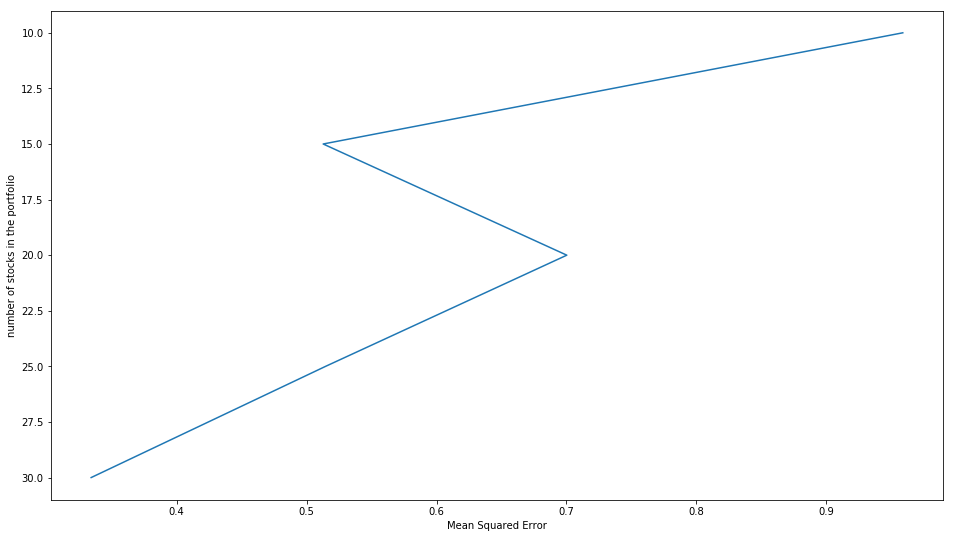

In [54]:
# Plot Efficient Deep Frontier

mse = [t/122 for t in error]
plt.gca().invert_yaxis()
plt.plot(mse, list(range(10,31,5)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 